In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report , accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import roc_curve
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
path = r"Data\adult1.csv"

In [3]:
df = pd.read_csv(path)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


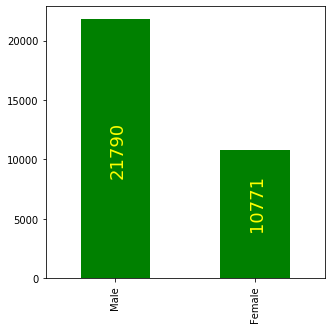

In [4]:
m_f = df.sex.value_counts()
fig = m_f.plot(kind="bar", figsize=[5,5], color="green")
for x,y in enumerate(m_f):
    fig.text(x-0.05 , y*0.4, y, rotation=90, color="yellow", fontsize=18)

In [5]:
german_per = df[df["native-country"]=="Germany"].shape[0]/df.shape[0]
german_per

0.004207487485028101

In [6]:
sal50K = df[df["salary"]==">50K"]
sal50K["age"].mean(), sal50K["age"].std()

(44.24984058155847, 10.51902771985177)

In [7]:
df.salary.value_counts()

<=50K    24720
>50K      7841
Name: salary, dtype: int64

In [8]:
Amer_Indian_Eskimo_Male_max_age = df.groupby(["race","sex"])[["age"]].describe().loc["Amer-Indian-Eskimo","Male"]["age"]["max"]
Amer_Indian_Eskimo_Male_max_age

82.0

In [9]:
df.salary = df["salary"].replace({"<=50K":0, ">50K":1})

In [10]:
df.select_dtypes('object').columns

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')

In [11]:
df = df.replace("?", np.nan)

In [12]:
df = df.dropna()

In [13]:
for col in df.select_dtypes('object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [14]:
X = df.drop(columns="salary")
y = df.salary
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [15]:
dt = DecisionTreeClassifier()
dt.fit(X_train_val, y_train_val)
dt.score(X_test_val, y_test_val)

0.8103244139237509

In [16]:
vot_cla = VotingClassifier([("Decision Tree", DecisionTreeClassifier()), ("Random Forest", RandomForestClassifier(max_depth=6, n_estimators=50)), ("Random Forest 2", RandomForestClassifier(max_depth=6, n_estimators=50)), ("Logistic Regression", LogisticRegression())], voting='soft')
vot_cla.fit(X_train_val, y_train_val)
vot_cla.score(X_test_val, y_test_val)

0.84252900781435

In [17]:
vot_cla.score(X_test, y_test)

0.8360039783401481

In [18]:
gboost = GradientBoostingClassifier(n_estimators=50, max_depth=6)
gboost.fit(X_train_val, y_train_val)
gboost.score(X_test_val, y_test_val)

0.8673928486857684

In [19]:
gboost = GradientBoostingClassifier(n_estimators=100, max_depth=6)
gboost.fit(X_train_val, y_train_val)
gboost.score(X_test_val, y_test_val)

0.8652616623253612

In [20]:
imp_fea = pd.DataFrame({"feature":X_train.columns, "score":gboost.feature_importances_})

In [21]:
imp_fea = imp_fea.sort_values("score", ascending=False).head(10)

In [22]:
imp_fea.index = imp_fea.feature
imp_fea.drop(columns="feature", inplace=True)

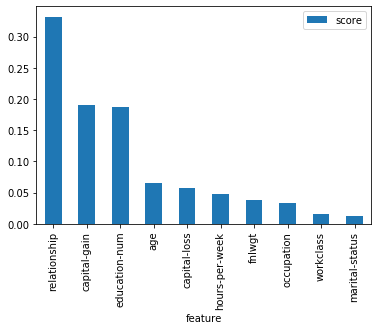

In [23]:
imp_fea.plot(kind="bar")

In [24]:
gboost_10 = GradientBoostingClassifier(n_estimators=10, max_depth=6)
gboost_50 = GradientBoostingClassifier(n_estimators=50, max_depth=6)
gboost_100 = GradientBoostingClassifier(n_estimators=100, max_depth=6)

In [25]:
gboost_10.fit(X_train_val, y_train_val)
train_err_10 = 1-(gboost_10.score(X_train_val, y_train_val))

In [26]:
gboost_50.fit(X_train_val, y_train_val)
train_err_50 = 1-(gboost_50.score(X_train_val, y_train_val))

In [27]:
gboost_100.fit(X_train_val, y_train_val)
train_err_100 = 1-(gboost_100.score(X_train_val, y_train_val))

In [28]:
training_errors = [train_err_10, train_err_50, train_err_100]
training_errors

[0.14422735346358795, 0.1149792776791001, 0.09798697454114857]

In [29]:
validation_err_10 = 1-(gboost_10.score(X_test_val, y_test_val))
validation_err_50 = 1-(gboost_50.score(X_test_val, y_test_val))
validation_err_100 = 1-(gboost_100.score(X_test_val, y_test_val))
validation_errors = [validation_err_10, validation_err_50,validation_err_100]
validation_errors

[0.14705185886810324, 0.13308074828321104, 0.13710632251953592]

In [30]:
testing_err_10 = 1-(gboost_10.score(X_test, y_test))
testing_err_50 = 1-(gboost_50.score(X_test, y_test))
testing_err_100 = 1-(gboost_100.score(X_test, y_test))
testing_errors = [testing_err_10, testing_err_50,testing_err_100]
testing_errors

[0.1554867941208974, 0.13670018786606253, 0.13482152724057905]

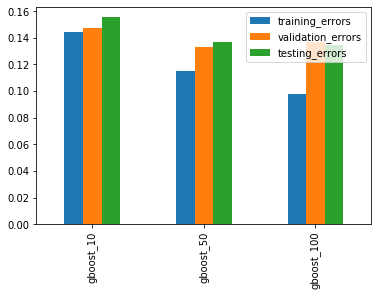

In [31]:
pd.DataFrame([training_errors, validation_errors, testing_errors], index=["training_errors", "validation_errors", "testing_errors"], columns=["gboost_10", "gboost_50", "gboost_100"]).T.plot(kind="bar")